# This script demonstrates how to build a multi-modal variational autoencoder with vae_tools

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.loader
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt

keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


In [2]:
# Get the MNIST digits and fashion data set
shape = (28, 28, 1)
#x_train, w_train, label_train, x_test, w_test, label_test = vae_tools.loader.mnist_digit_fashion(
#    new_shape = shape, flatten = True, shuffle = True)
x_train, w_train, label_train, x_test, w_test, label_test = vae_tools.loader.emnist(flatten = True)

A: [<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 784) dtype=float32>]
A: [<tf.Tensor 'input_2:0' shape=(?, 784) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 784) dtype=float32>]
Store model to filename: tmp/myMmVAE.png and tmp/myMmVAE.svg
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 784)          0                                            
______________________________________________________________

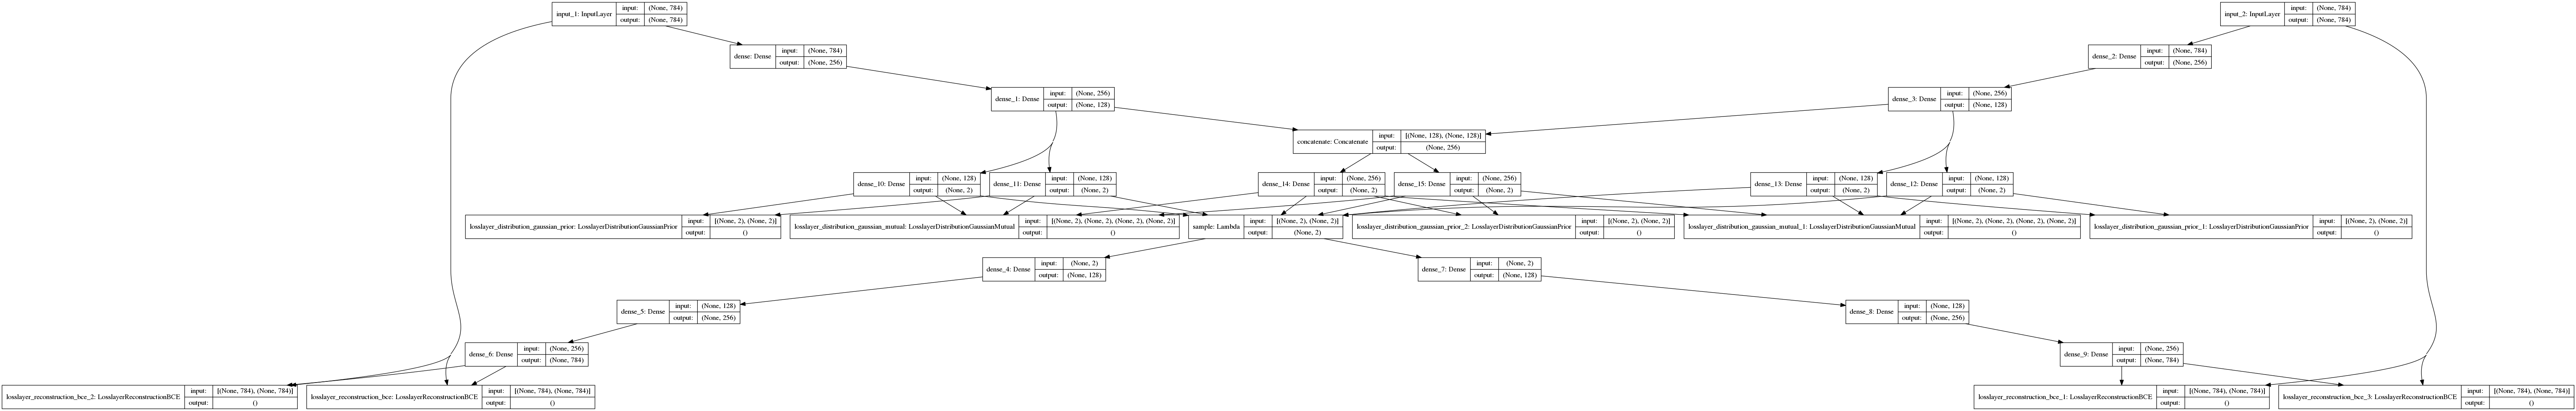

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = shape[0], shape[1], shape[2]
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 5
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(original_dim,)),                       # Input layer of x
    Dense(intermediate_dim, activation='relu'),         # First encoder layer of x
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer of x
],[
    Input(shape=(original_dim,)),                       # Input layer of w
    Dense(intermediate_dim, activation='relu'),         # First encoder layer of w
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer of w
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer of x
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer of x
    Dense(original_dim, activation='sigmoid')           # Output layer of x
],[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer of w
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer of w
    Dense(original_dim, activation='sigmoid')           # Output layer of w
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim, original_dim], 
                beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='MmVae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myMmVAE', print_svg = False, verbose = True)

In [5]:
# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/emnist'

writer = tf.summary.FileWriter(log_dir) # Get a writer for our own callbacks
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
tblosses_cb = vae_tools.callbacks.TbLosses(writer = writer, data = [x_test, w_test], log_dir=log_dir)
tbembedding_x_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = label_test, log_dir=log_dir, tag = "embedding/x")
tbembedding_w_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = w_test, encoder_model = vae_obj.get_encoder_mean([encoder[1][0]]), labels = label_test, log_dir=log_dir, tag = "embedding/w")
tbembedding_xw_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = [x_test, w_test], encoder_model = vae_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]), labels = label_test, log_dir=log_dir, tag = "embedding/xw")
tbdecoding_x_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(decoder_output_list = [decoder[0][-1]]), log_dir=log_dir, tag = "decoding/x")
tbdecoding_w_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(decoder_output_list = [decoder[1][-1]]), log_dir=log_dir, tag = "decoding/w")
# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = [x_train, w_train])
# Train
vae.fit([x_train, w_train],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, w_test], None),
            verbose = 0,
            callbacks=[losses_cb, tb_cb, tblosses_cb,
                       tbembedding_w_cb, tbembedding_x_cb, tbembedding_xw_cb,
                       tbdecoding_x_cb, tbdecoding_w_cb,
                       losses_cb])

Train on 59400 samples, validate on 600 samples
Epoch 1/5
59400/59400 [==============================] - 18s 310us/step - loss: 1383.5791 - val_loss: 1201.2714
Epoch 2/5
59400/59400 [==============================] - 17s 279us/step - loss: 1150.6235 - val_loss: 1090.3118
Epoch 3/5
59400/59400 [==============================] - 17s 286us/step - loss: 1070.0696 - val_loss: 1063.8260
Epoch 4/5
59400/59400 [==============================] - 17s 289us/step - loss: 1049.3847 - val_loss: 1027.8251
Epoch 5/5
59400/59400 [==============================] - 17s 286us/step - loss: 1036.6437 - val_loss: 1021.6714


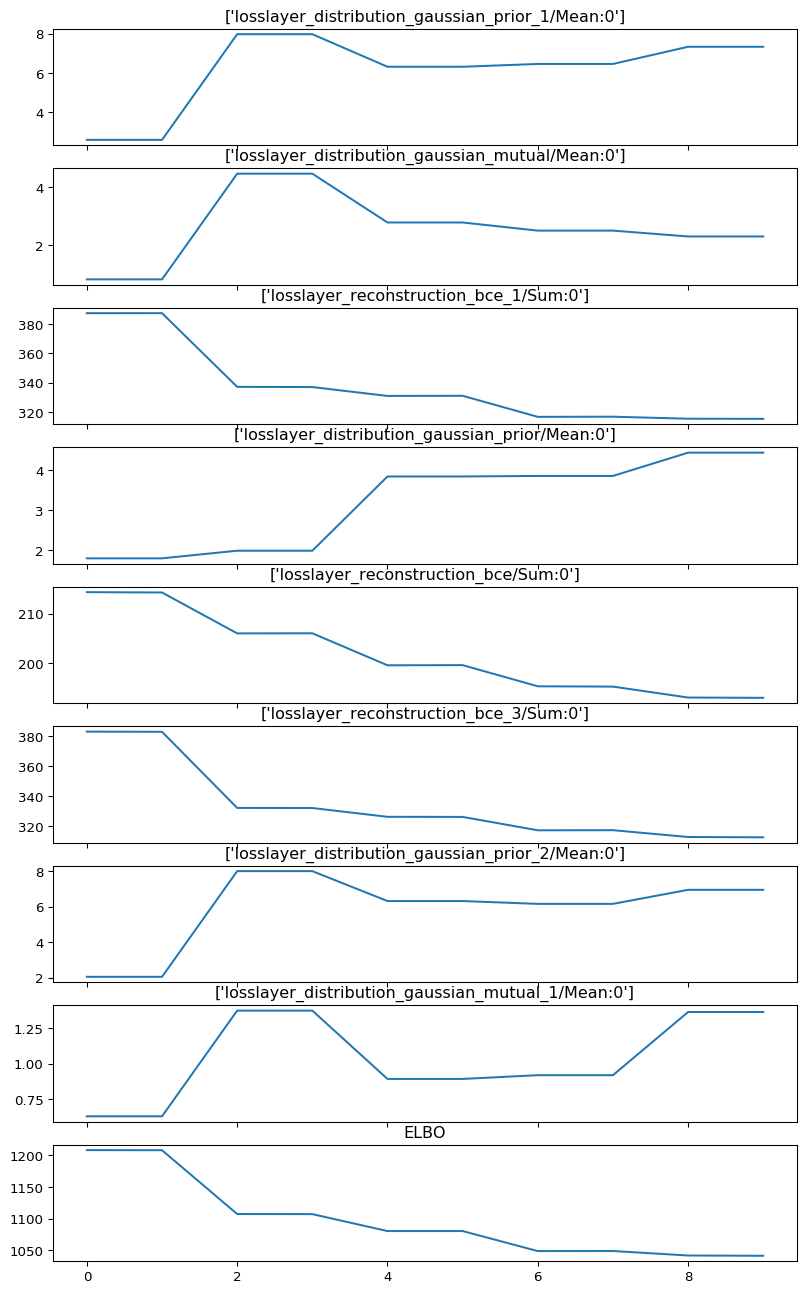

In [7]:
# Show the losses
f, axs = plt.subplots(len(list(losses_cb.history.values())), 1, sharex=True, figsize=[10,17], dpi=96)
for idx in range(len(axs)-1):
    axs[idx].plot(list(losses_cb.history.values())[idx])
    axs[idx].set_title([list(losses_cb.history.keys())[idx]])
axs[-1].plot([sum(values) for values in zip(*list(losses_cb.history.values()))])
axs[-1].set_title("ELBO")
plt.show()

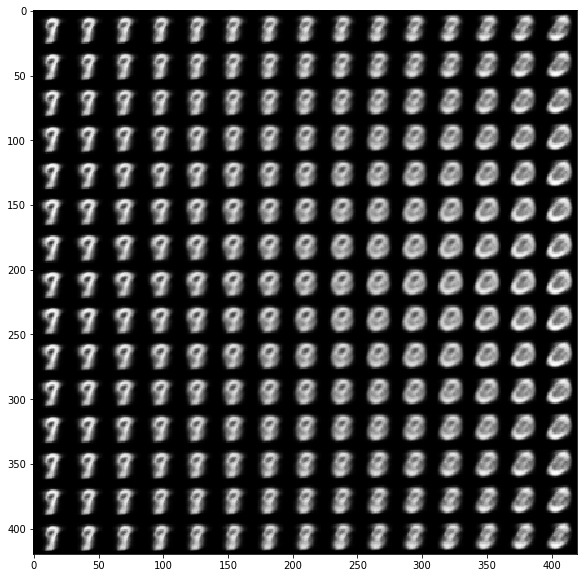

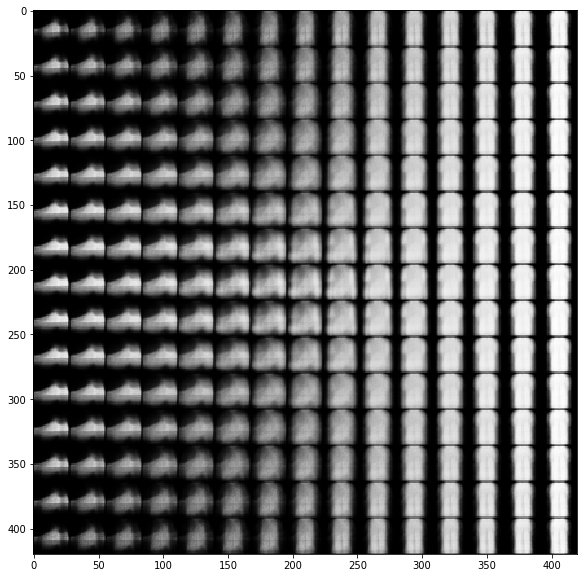

In [8]:
def plot_modality(modality):
    # build a digit generator that can sample from the learned distribution
    generator = vae_obj.get_decoder()
    from scipy.stats import norm
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[modality].reshape(digit_size, digit_size)
            figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
plot_modality(0)
plot_modality(1)

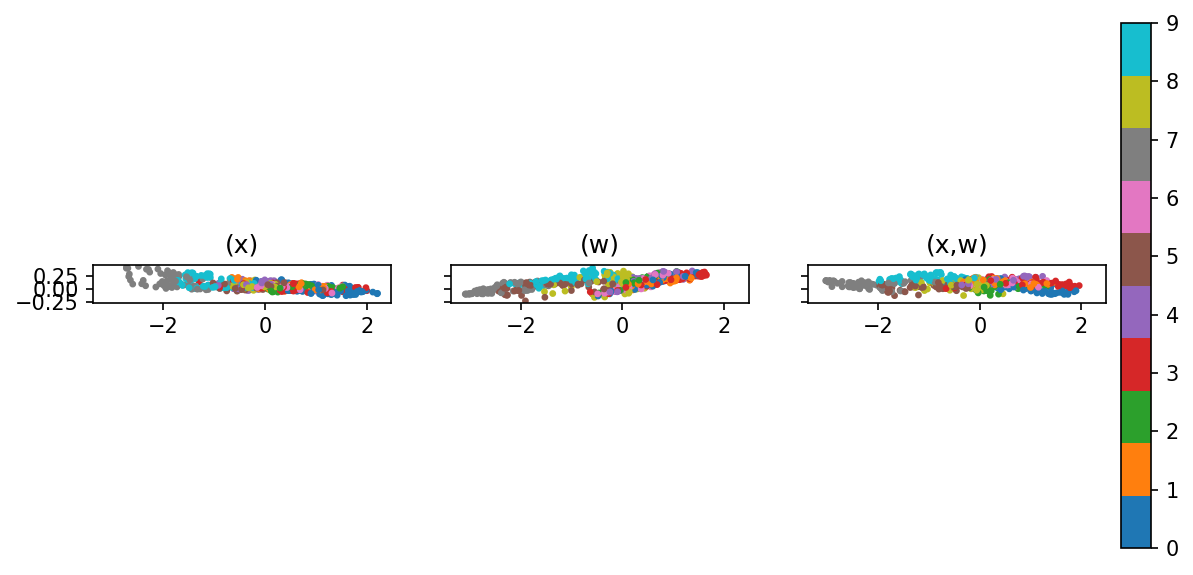

In [9]:
# Show the losses
f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=[10,5], dpi=150)

def get_encoded_data(vae_obj, encoder_inputs, data):
    encoder_model = vae_obj.get_encoder_mean(encoder_inputs)
    return encoder_model.predict(data, batch_size=batch_size)

# Plot the encodings
z = get_encoded_data(vae_obj, vae_obj.encoder_inputs_powerset[0], [x_test])
axs[0].scatter(z[:, 0], z[:, 1], c=label_test, cmap='tab10', s = 5.)
axs[0].set_title("(x)")
z = get_encoded_data(vae_obj, vae_obj.encoder_inputs_powerset[1], [w_test])
axs[1].scatter(z[:, 0], z[:, 1], c=label_test, cmap='tab10', s = 5.)
axs[1].set_title("(w)")
z = get_encoded_data(vae_obj, vae_obj.encoder_inputs_powerset[2], [x_test, w_test])
sct = axs[2].scatter(z[:, 0], z[:, 1], c=label_test, cmap='tab10', s = 5.)
axs[2].set_title("(x,w)")

# Make axis equal
vae_tools.viz.set_xy_equal_lim(axs)
for ax in axs:
    ax.set_aspect('equal', 'box')
# Set the colorbar
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.81, 0.15, 0.02, 0.7])
f.colorbar(sct, cax=cbar_ax)

plt.show()